<a href="https://colab.research.google.com/github/SiriBatchu/Neural-Networks/blob/main/Tensorflow_Without_HighLevelAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch    0: Train Loss = 227.9319, Val Loss = 216.0261
Epoch   10: Train Loss = 108.4296, Val Loss = 99.5734
Epoch   20: Train Loss = 88.9419, Val Loss = 77.3057
Epoch   30: Train Loss = 82.0698, Val Loss = 68.1804
Epoch   40: Train Loss = 73.2358, Val Loss = 66.1385
Epoch   50: Train Loss = 71.4836, Val Loss = 61.9979
Epoch   60: Train Loss = 62.0356, Val Loss = 55.3542
Epoch   70: Train Loss = 53.1313, Val Loss = 44.8092
Epoch   80: Train Loss = 50.2393, Val Loss = 36.0905
Epoch   90: Train Loss = 44.8871, Val Loss = 31.2817


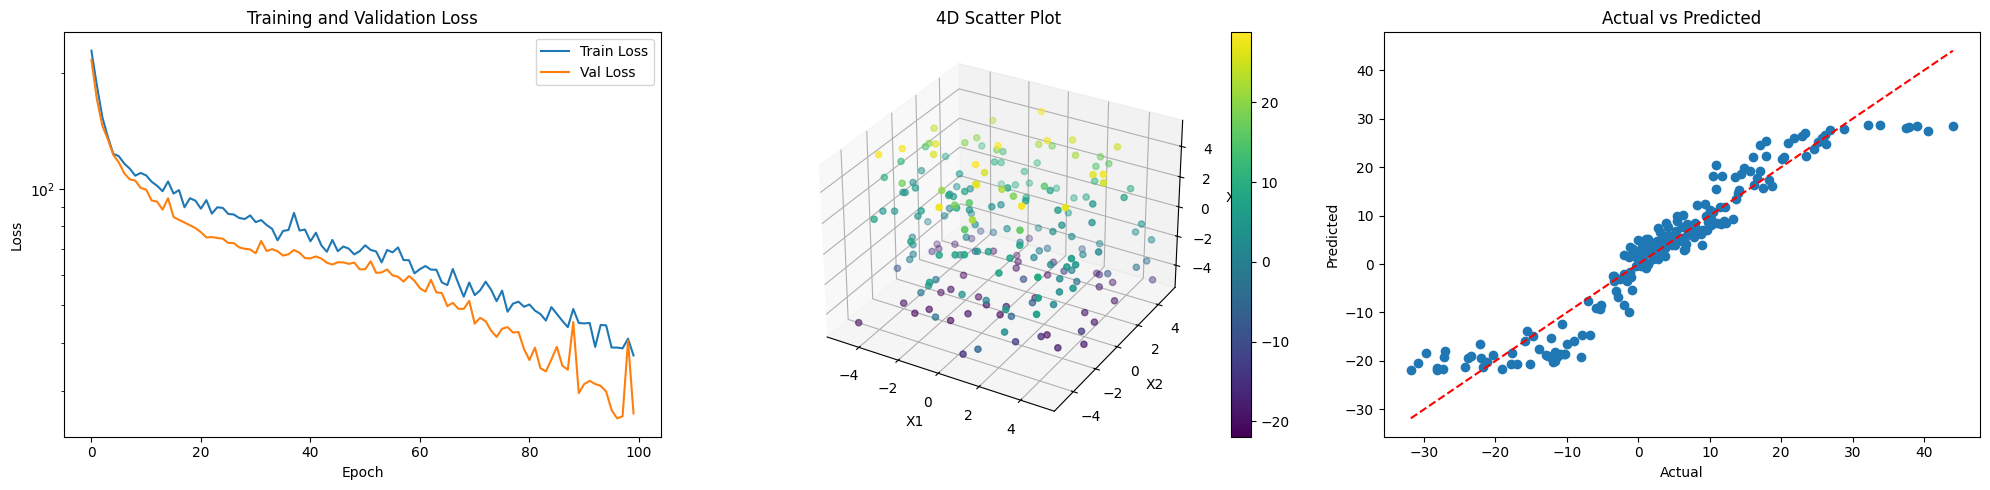


Test Predictions:
Input: (-4, -4, -4)
Prediction: -16.318
Actual: -10.644
Difference: 5.674

Input: (-2, -2, -2)
Prediction: -1.037
Actual: -2.872
Difference: 1.836

Input: ( 0,  0,  0)
Prediction: 2.511
Actual: 1.000
Difference: 1.511

Input: ( 2,  2,  2)
Prediction: 6.879
Actual: 5.565
Difference: 1.314

Input: ( 4,  4,  4)
Prediction: 25.682
Actual: 24.729
Difference: 0.953



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds
tf.random.set_seed(42)
np.random.seed(42)

class NonLinearRegressor:
    def __init__(self, learning_rate=0.001):
        # Initialize weights using He initialization
        self.W1 = tf.Variable(
            tf.random.normal([3, 64]) * tf.sqrt(2.0/3),
            name='W1'
        )
        self.b1 = tf.Variable(tf.zeros([64]), name='b1')

        self.W2 = tf.Variable(
            tf.random.normal([64, 32]) * tf.sqrt(2.0/64),
            name='W2'
        )
        self.b2 = tf.Variable(tf.zeros([32]), name='b2')

        self.W3 = tf.Variable(
            tf.random.normal([32, 16]) * tf.sqrt(2.0/32),
            name='W3'
        )
        self.b3 = tf.Variable(tf.zeros([16]), name='b3')

        self.W4 = tf.Variable(
            tf.random.normal([16, 1]) * tf.sqrt(2.0/16),
            name='W4'
        )
        self.b4 = tf.Variable(tf.zeros([1]), name='b4')

        self.learning_rate = learning_rate
        self.training = True

    def relu(self, x):
        return tf.maximum(0.0, x)

    def layer_norm(self, x, epsilon=1e-5):
        mean, variance = tf.nn.moments(x, axes=[1], keepdims=True)
        normalized = (x - mean) / tf.sqrt(variance + epsilon)
        return normalized

    @tf.function
    def forward(self, x, training=True):
        # First hidden layer
        z1 = tf.matmul(x, self.W1) + self.b1
        z1 = self.layer_norm(z1)
        a1 = self.relu(z1)
        if training:
            a1 = tf.nn.dropout(a1, rate=0.2)

        # Second hidden layer
        z2 = tf.matmul(a1, self.W2) + self.b2
        z2 = self.layer_norm(z2)
        a2 = self.relu(z2)
        if training:
            a2 = tf.nn.dropout(a2, rate=0.2)

        # Third hidden layer
        z3 = tf.matmul(a2, self.W3) + self.b3
        z3 = self.layer_norm(z3)
        a3 = self.relu(z3)
        if training:
            a3 = tf.nn.dropout(a3, rate=0.2)

        # Output layer
        output = tf.matmul(a3, self.W4) + self.b4
        return output

    @tf.function
    def compute_loss(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred))

    @tf.function
    def train_step(self, x_batch, y_batch):
        with tf.GradientTape() as tape:
            predictions = self.forward(x_batch, training=True)
            loss = self.compute_loss(y_batch, predictions)

        # Get trainable variables
        trainable_vars = [self.W1, self.b1, self.W2, self.b2,
                         self.W3, self.b3, self.W4, self.b4]

        # Compute gradients
        gradients = tape.gradient(loss, trainable_vars)

        # Apply gradients
        for var, grad in zip(trainable_vars, gradients):
            var.assign_sub(self.learning_rate * grad)

        return loss

    @tf.function
    def evaluate(self, x, y):
        predictions = self.forward(x, training=False)
        loss = self.compute_loss(y, predictions)
        return loss, predictions

def generate_data(n_samples=1000):
    X1 = np.random.uniform(-5, 5, n_samples)
    X2 = np.random.uniform(-5, 5, n_samples)
    X3 = np.random.uniform(-5, 5, n_samples)

    # Non-linear function with 3 variables
    y = (2 * np.sin(X1) + 0.5 * X2**2 + 0.3 * X3**3 +
         np.cos(X1 * X2) + np.random.normal(0, 0.2, n_samples))

    X = np.column_stack((X1, X2, X3))
    return (tf.convert_to_tensor(X, dtype=tf.float32),
            tf.convert_to_tensor(y.reshape(-1, 1), dtype=tf.float32))

def create_batches(X, y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

def train_model(model, train_data, val_data, epochs=100, batch_size=32):
    train_losses = []
    val_losses = []

    # Create batched datasets
    train_dataset = create_batches(train_data[0], train_data[1], batch_size)

    for epoch in range(epochs):
        epoch_losses = []

        # Training
        for x_batch, y_batch in train_dataset:
            loss = model.train_step(x_batch, y_batch)
            epoch_losses.append(loss)

        avg_train_loss = tf.reduce_mean(epoch_losses)
        train_losses.append(avg_train_loss)

        # Validation
        val_loss, _ = model.evaluate(val_data[0], val_data[1])
        val_losses.append(val_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:4d}: Train Loss = {avg_train_loss:.4f}, "
                  f"Val Loss = {val_loss:.4f}")

    return train_losses, val_losses

def plot_results(model, train_losses, val_losses, test_data):
    plt.figure(figsize=(20, 5))

    # Plot training history
    plt.subplot(131)
    plt.plot([loss.numpy() for loss in train_losses], label='Train Loss')
    plt.plot([loss.numpy() for loss in val_losses], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()

    # Get test predictions
    _, y_pred = model.evaluate(test_data[0], test_data[1])

    # Plot 4D scatter
    ax = plt.subplot(132, projection='3d')
    scatter = ax.scatter(test_data[0][:, 0],
                        test_data[0][:, 1],
                        test_data[0][:, 2],
                        c=y_pred.numpy().ravel(),
                        cmap='viridis')
    plt.colorbar(scatter)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    plt.title('4D Scatter Plot')

    # Plot actual vs predicted
    plt.subplot(133)
    plt.scatter(test_data[1].numpy(), y_pred.numpy())
    plt.plot([test_data[1].numpy().min(), test_data[1].numpy().max()],
             [test_data[1].numpy().min(), test_data[1].numpy().max()],
             'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')

    plt.tight_layout()
    plt.show()

def main():
    # Generate datasets
    X_train, y_train = generate_data(1000)
    X_val, y_val = generate_data(200)
    X_test, y_test = generate_data(200)

    # Create and train model
    model = NonLinearRegressor(learning_rate=0.001)
    train_losses, val_losses = train_model(
        model,
        (X_train, y_train),
        (X_val, y_val),
        epochs=100,
        batch_size=32
    )

    # Plot results
    plot_results(model, train_losses, val_losses, (X_test, y_test))

    # Test predictions
    test_points = tf.constant([
        [-4, -4, -4],
        [-2, -2, -2],
        [0, 0, 0],
        [2, 2, 2],
        [4, 4, 4]
    ], dtype=tf.float32)

    predictions = model.forward(test_points, training=False)

    print("\nTest Predictions:")
    for i, (x1, x2, x3) in enumerate(test_points.numpy()):
        actual = 2 * np.sin(x1) + 0.5 * x2**2 + 0.3 * x3**3 + np.cos(x1 * x2)
        pred = predictions[i][0].numpy()
        print(f"Input: ({x1:2.0f}, {x2:2.0f}, {x3:2.0f})")
        print(f"Prediction: {pred:.3f}")
        print(f"Actual: {actual:.3f}")
        print(f"Difference: {abs(pred - actual):.3f}\n")

if __name__ == "__main__":
    main()